In [ ]:
!pip install nltk

In [ ]:
!pip install tqdm

In [ ]:
import json
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

### Process genuine and fake data separately

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
root_path = "/content/drive/MyDrive/Bot_detection/cresci tweets/cresci 2015"

In [ ]:
# Genuine Data Read in
genuine_data_file = ["E13_tweets.csv", "TFP_tweets.csv"]

try:
    df_genuine_combined = pd.DataFrame()
    common_columns = None

    # Load the genuine data
    for file in genuine_data_file:
        try:
            df = pd.read_csv(f'{root_path}/{file}', encoding='latin_1')

            if df_genuine_combined.empty:
                # This is the first file - initialize df_combined and common_columns
                df_genuine_combined = df
                common_columns = set(df.columns)
            else:
                # This is a subsequent file - update common_columns and append only common columns to df_combined
                common_columns &= set(df.columns)
                df_genuine_combined = pd.concat([df_genuine_combined, df[common_columns]])

            print(f"{file} loaded successfully with 'latin_1' encoding.")
        except Exception as e:
            print(f"Error while reading the {file} CSV file:", e)


except Exception as e:

        print("Error while reading the CSV file:", e)




E13_tweets.csv loaded successfully with 'latin_1' encoding.


<ipython-input-6-cbe015ae8928>:20: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_genuine_combined = pd.concat([df_genuine_combined, df[common_columns]])


TFP_tweets.csv loaded successfully with 'latin_1' encoding.


In [ ]:
df_genuine_combined.shape

(2631730, 19)

In [ ]:
# Calculate the number of unique ids
num_unique_ids = df_genuine_combined['user_id'].nunique()

num_unique_ids

1946

In [ ]:
# Read fake data
fake_data_file =['FSF_tweets.csv', 'INT_tweets.csv', 'TWT_tweets.csv']

df_fake_combined = pd.DataFrame()
common_columns = None

# Load the fake data
for file in fake_data_file:
    try:
        df = pd.read_csv(f'{root_path}/{file}', encoding='latin_1')

        if df_fake_combined.empty:
            # This is the first file - initialize df_combined and common_columns
            df_fake_combined = df
            common_columns = set(df.columns)
        else:
            # This is a subsequent file - update common_columns and append only common columns to df_combined
            common_columns &= set(df.columns)
            df_fake_combined = pd.concat([df_fake_combined, df[common_columns]])

        print(f"{file} loaded successfully with 'latin_1' encoding.")
    except Exception as e:
        print(f"Error while reading the {file} CSV file:", e)

FSF_tweets.csv loaded successfully with 'latin_1' encoding.


<ipython-input-9-af097842bc14>:10: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{root_path}/{file}', encoding='latin_1')
<ipython-input-9-af097842bc14>:19: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_fake_combined = pd.concat([df_fake_combined, df[common_columns]])


INT_tweets.csv loaded successfully with 'latin_1' encoding.
TWT_tweets.csv loaded successfully with 'latin_1' encoding.


<ipython-input-9-af097842bc14>:19: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_fake_combined = pd.concat([df_fake_combined, df[common_columns]])


In [ ]:
df_fake_combined.shape

(196027, 19)

In [ ]:
expected_columns_fake= df_fake_combined.columns.tolist()
expected_columns_fake

['created_at',
 'id',
 'text',
 'source',
 'user_id',
 'truncated',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'in_reply_to_screen_name',
 'retweeted_status_id',
 'geo',
 'place',
 'retweet_count',
 'reply_count',
 'favorite_count',
 'num_hashtags',
 'num_urls',
 'num_mentions',
 'timestamp']

In [ ]:
expected_columns_genuine = df_genuine_combined.columns.tolist()
expected_columns_genuine

['created_at',
 'id',
 'text',
 'source',
 'user_id',
 'truncated',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'in_reply_to_screen_name',
 'retweeted_status_id',
 'geo',
 'place',
 'retweet_count',
 'reply_count',
 'favorite_count',
 'num_hashtags',
 'num_urls',
 'num_mentions',
 'timestamp']

In [ ]:
mismatched_columns = list(set(expected_columns_genuine) - set(expected_columns_fake))
mismatched_columns

[]

In [ ]:
# Drop unmatched columns
df_genuine_combined.drop(mismatched_columns, axis=1, inplace=True)

In [ ]:
# Check unmatched columns again
expected_columns_genuine_2nd = df_genuine_combined.columns.tolist()

mismatched_columns_2nd = list(set(expected_columns_genuine_2nd) - set(expected_columns_fake))
mismatched_columns_2nd

[]

In [ ]:
!pip install hydra-core

In [ ]:
!pip install transformers

In [ ]:
import torch
import numpy as np
from transformers import DistilBertModel, DistilBertTokenizer

In [ ]:
class DistilBERT:
    def __init__(self, batch_size=16):
        """ Initialize Distil-BERT model """
        self.model_name = 'distilbert-base-cased'
        self.model_class = DistilBertModel
        self.tokenizer_class = DistilBertTokenizer

        self.tokenizer = self.tokenizer_class.from_pretrained(self.model_name)
        self.model = self.model_class.from_pretrained(self.model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)

        self.batch_size=batch_size

    def embed(self, samples):
        n = len(samples)
        features = []

        for i in range(0, n, self.batch_size):
            batch = samples[i:i+self.batch_size]
            encoded_input = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
            encoded_input = {key: value.to(self.device) for key, value in encoded_input.items()}

            with torch.no_grad():
                last_hidden_states = self.model(**encoded_input)

            batch_features = last_hidden_states.last_hidden_state[:, 0, :].cpu().numpy()
            features.extend(batch_features)

        return np.array(features)

# Test the modified class
distil_bert = DistilBERT()
print("Success!") if distil_bert else print("Fail!")


Success!


In [ ]:
df_genuine_data_200k_seg = df_genuine_combined.head(200000)

In [ ]:
# data_g = df_genuine_data_20k_seg.dropna(subset=['text'])
data_g_200k = df_genuine_data_200k_seg.dropna(subset=['text'])
data_g_200k.shape
# data_g_full = df_genuine_data.dropna(subset=['text'])
# data_g_full.shape

(199979, 19)

In [ ]:
# data_f = df_fake_data_20k_seg.dropna(subset=['text'])
data_f_200k = df_fake_combined.dropna(subset=['text'])
data_f_200k.shape
# data_f_full = df_fake_combined.dropna(subset=['text'])
# data_f_full.shape

(196007, 19)

In [ ]:
import os

In [ ]:
df_genuine_subset_name = f'{root_path}/df_genuine_data_200k_seg_droped_null.csv'

try:
  if os.path.exists(df_genuine_subset_name):
    os.remove(df_genuine_subset_name)
except Exception as e:
    print(f"Error occurred while removing the file: {str(e)}")

data_g_200k.to_csv(df_genuine_subset_name, index=False)

In [ ]:
df_fake_subset_name = f'{root_path}/df_fake_data_200k_seg_droped_null.csv'

try:
  if os.path.exists(df_fake_subset_name):
    os.remove(df_fake_subset_name)
except Exception as e:
    print(f"Error occurred while removing the file: {str(e)}")

data_f_200k.to_csv(df_fake_subset_name, index=False)

In [ ]:
data_g_200k = pd.read_csv(f'{root_path}/df_genuine_data_200k_seg_droped_null.csv',encoding = 'latin_1')
data_f_200k = pd.read_csv(f'{root_path}/df_fake_data_200k_seg_droped_null.csv',encoding = 'latin_1')

<ipython-input-26-ccb6457341f9>:2: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data_f_200k = pd.read_csv(f'{root_path}/df_fake_data_200k_seg_droped_null.csv',encoding = 'latin_1')


In [ ]:
print(data_f_200k.shape)
print(data_g_200k.shape)

(196007, 19)
(199979, 19)


In [ ]:
# Function to process texts in batch
def process_texts(data, distil_bert):
    embeddings = []
    data = data.tolist()  # Convert the Series to a list
    for i in tqdm.tqdm(range(0, len(data), distil_bert.batch_size), total=int(len(data) / distil_bert.batch_size), desc='Processing'):
        batch_texts = data[i:i+distil_bert.batch_size]
        batch_embedding = distil_bert.embed(batch_texts)
        embeddings.append(batch_embedding)
    return np.concatenate(embeddings)

genuine_embeddings_full_no_preprocessing = process_texts(data_g_200k['text'], distil_bert)
fake_embeddings_full_no_preprocessing = process_texts(data_f_200k['text'], distil_bert)

np.save(f'{root_path}/genuine_embeddings_200k_no_preprocessing.npy', genuine_embeddings_full_no_preprocessing)
np.save(f'{root_path}/fake_embeddings_200k_no_preprocessing.npy', fake_embeddings_full_no_preprocessing)


Processing: 12499it [06:47, 30.68it/s]
Processing: 12251it [06:25, 31.79it/s]                           


In [ ]:
import numpy as np

In [ ]:
# genuine_embeddings = np.load(f'{root_path}/genuine_embeddings_20k_no_preprocessing.npy', allow_pickle=True)
# fake_embeddings = np.load(f'{root_path}/fake_embeddings_20k_no_preprocessing.npy', allow_pickle=True)

# genuine_embeddings.shape, fake_embeddings.shape

genuine_embeddings_200k = np.load(f'{root_path}/genuine_embeddings_no_preprocessing.npy', allow_pickle=True)
fake_embeddings_200k = np.load(f'{root_path}/fake_embeddings_no_preprocessing.npy', allow_pickle=True)

genuine_embeddings_200k.shape, fake_embeddings_200k.shape

((196008, 1, 768), (196007, 1, 768))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Flatten the embeddings
genuine_embeddings_200k_flat = genuine_embeddings_200k.reshape(genuine_embeddings_200k.shape[0], -1)
fake_embeddings_200k_flat = fake_embeddings_200k.reshape(fake_embeddings_200k.shape[0], -1)

all_embeddings_200k = np.concatenate([genuine_embeddings_200k_flat, fake_embeddings_200k_flat])

In [ ]:
from sklearn.cluster import KMeans

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(all_embeddings_200k)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
cluster_labels = kmeans.labels_

genuine_cluster_labels_200k = cluster_labels[:len(genuine_embeddings_200k_flat)]
fake_cluster_labels_200k = cluster_labels[len(fake_embeddings_200k_flat):]

genuine_cluster_0 = np.mean(genuine_cluster_labels_200k == 0)
genuine_cluster_1 = np.mean(genuine_cluster_labels_200k == 1)
fake_cluster_0 = np.mean(fake_cluster_labels_200k == 0)
fake_cluster_1 = np.mean(fake_cluster_labels_200k == 1)

genuine_cluster_0, genuine_cluster_1, fake_cluster_0, fake_cluster_1

(0.3873617403371291,
 0.6126382596628709,
 0.5961950532631322,
 0.4038049467368679)

In [ ]:
import pickle

# Save the model
with open(f'{root_path}/kmeans_model_200k.pkl', 'wb') as file:
    pickle.dump(kmeans, file)


In [ ]:
import pickle

with open(f'{root_path}/kmeans_model_200k.pkl', 'rb') as file:
    kmeans = pickle.load(file)


cluster_labels = kmeans.labels_

genuine_cluster_labels_200k = cluster_labels[:len(genuine_embeddings_200k_flat)]
fake_cluster_labels_200k = cluster_labels[len(fake_embeddings_200k_flat):]

genuine_cluster_0 = np.mean(genuine_cluster_labels_200k == 0)
genuine_cluster_1 = np.mean(genuine_cluster_labels_200k == 1)
fake_cluster_0 = np.mean(fake_cluster_labels_200k == 0)
fake_cluster_1 = np.mean(fake_cluster_labels_200k == 1)

genuine_cluster_0, genuine_cluster_1, fake_cluster_0, fake_cluster_1

(0.3873617403371291,
 0.6126382596628709,
 0.5961950532631322,
 0.4038049467368679)

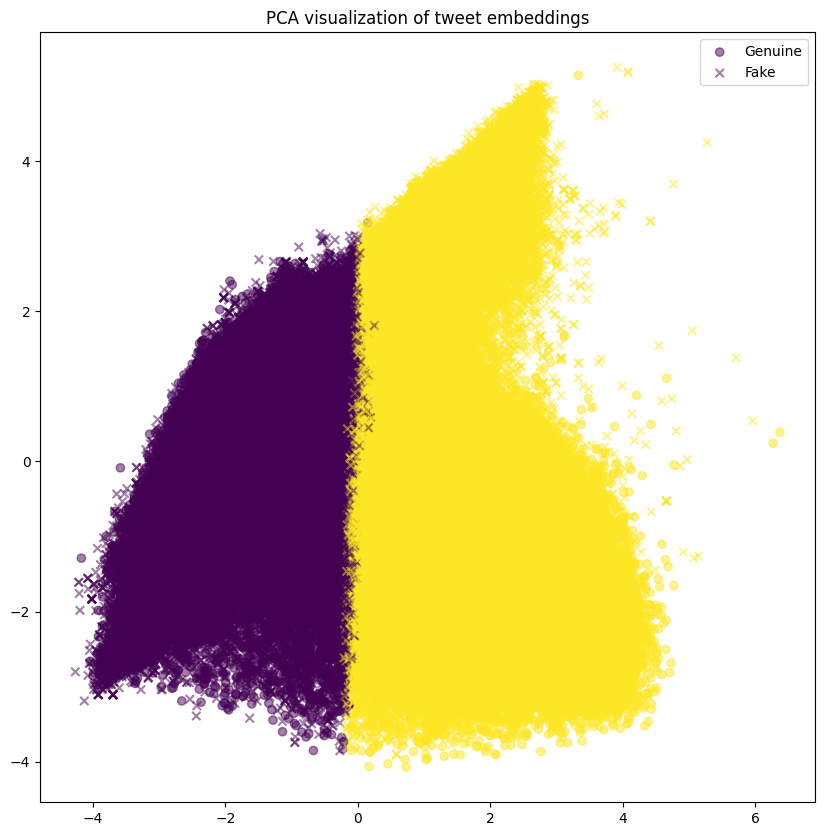

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
all_embeddings_2d = pca.fit_transform(all_embeddings_200k)

plt.figure(figsize=(10, 10))

plt.scatter(all_embeddings_2d[:len(genuine_embeddings_200k_flat), 0], all_embeddings_2d[:len(genuine_embeddings_200k_flat), 1],
            c=genuine_cluster_labels_200k, marker='o', alpha=0.5, label='Genuine')

plt.scatter(all_embeddings_2d[len(fake_embeddings_200k_flat):, 0], all_embeddings_2d[len(fake_embeddings_200k_flat):, 1],
            c=fake_cluster_labels_200k, marker='x', alpha=0.5, label='Fake')

plt.legend()
plt.title('PCA visualization of tweet embeddings')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, silhouette_score
from sklearn.utils import resample
import numpy as np

# Select a random sample of 20000 instances
n_samples = 20000
sampled_embeddings, sampled_cluster_labels = resample(all_embeddings_200k, cluster_labels, n_samples=n_samples, replace=False, random_state=0)

actual_labels = np.concatenate([np.zeros(len(genuine_embeddings_200k_flat)), np.ones(len(fake_embeddings_200k_flat))])

conf_matrix = confusion_matrix(actual_labels, cluster_labels)

if genuine_cluster_0 > genuine_cluster_1:
    predicted_labels = cluster_labels
else:
    predicted_labels = 1 - cluster_labels
f1 = f1_score(actual_labels, predicted_labels)

# Calculate the silhouette score for the sampled data
silhouette = silhouette_score(sampled_embeddings, sampled_cluster_labels, n_jobs=-1)

conf_matrix, f1, silhouette


(array([[ 75926, 120082],
        [116858,  79149]]),
 0.6011353143462683,
 0.14331612)

In [ ]:
correct_classifications = np.sum(predicted_labels == actual_labels)
incorrect_classifications = np.sum(predicted_labels != actual_labels)
total_points = len(actual_labels)

correct_percentage = (correct_classifications / total_points) * 100
incorrect_percentage = (incorrect_classifications / total_points) * 100

print(f'correct: {round(correct_percentage, 2)}%\nincorrect: {round(incorrect_percentage, 2)}%')

correct: 60.44%
incorrect: 39.56%
